## Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importando Base de Dados

In [2]:
feData = pd.read_csv('data/ifood-restaurants-february-2021.csv')
noData = pd.read_csv('data/ifood-restaurants-november-2020.csv')


In [3]:
feData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406399 entries, 0 to 406398
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   availableForScheduling  406399 non-null  bool   
 1   avatar                  406122 non-null  object 
 2   category                406399 non-null  object 
 3   delivery_fee            406399 non-null  float64
 4   delivery_time           406399 non-null  int64  
 5   distance                406399 non-null  float64
 6   ibge                    406399 non-null  int64  
 7   minimumOrderValue       406399 non-null  float64
 8   name                    406399 non-null  object 
 9   paymentCodes            406397 non-null  object 
 10  price_range             406399 non-null  object 
 11  rating                  406399 non-null  float64
 12  tags                    406399 non-null  object 
 13  url                     406399 non-null  object 
dtypes: bool(1), float64(

## Limpando Dados

Restaurantes que sobreviveram de novembro de 2020 até feveiro de 2021 (não incluiu restaurantes que fecharam antes de novembro de 2020)

In [4]:
data = feData[feData['url'].isin(noData['url'])]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317191 entries, 0 to 406398
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   availableForScheduling  317191 non-null  bool   
 1   avatar                  316929 non-null  object 
 2   category                317191 non-null  object 
 3   delivery_fee            317191 non-null  float64
 4   delivery_time           317191 non-null  int64  
 5   distance                317191 non-null  float64
 6   ibge                    317191 non-null  int64  
 7   minimumOrderValue       317191 non-null  float64
 8   name                    317191 non-null  object 
 9   paymentCodes            317191 non-null  object 
 10  price_range             317191 non-null  object 
 11  rating                  317191 non-null  float64
 12  tags                    317191 non-null  object 
 13  url                     317191 non-null  object 
dtypes: bool(1), float64(

<AxesSubplot: ylabel='Frequency'>

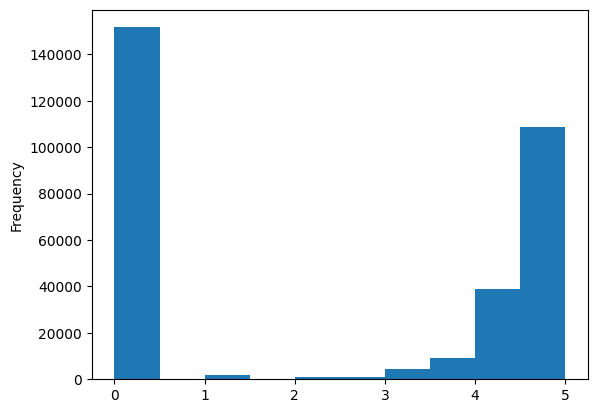

In [5]:
#plot 'rating' distribuition 
data['rating'].plot.hist(bins=10)

Removendo restaurantes com avaliações iguais a **0** ou iguais a **5**

In [6]:
#removendo restaurantes com rating == 0 
data = data[(data['rating'] != 0)&(data['rating'] != 5)]
data = data.reset_index(drop=True)

<AxesSubplot: ylabel='Frequency'>

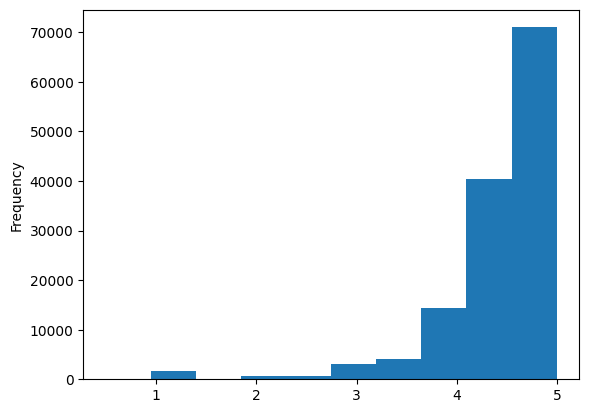

In [7]:
data['rating'].plot.hist(bins=10)

<AxesSubplot: >

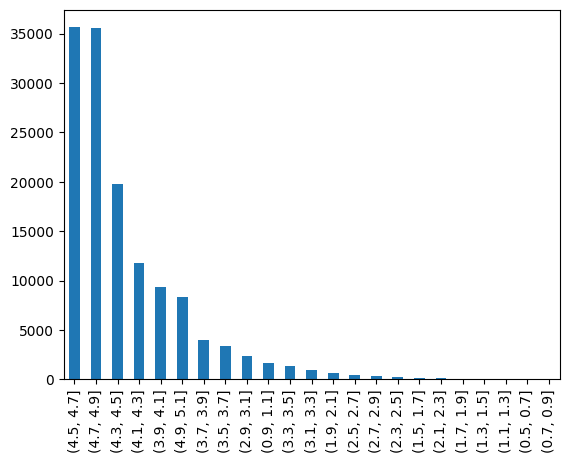

In [8]:
data['rating_bin'] = pd.cut(data['rating'], np.arange(0.5, 5.2, 0.2))
data['rating_bin'].value_counts().plot.bar()

Analisando o gráfico, podemos ver que as notas se aproximam, no geral, bastante de 5, por isso, para que possamos analisar as características dos restaurantes mais bem avaliados, podemos divdir o dataset em dois grupos. O grupo elite, com as maiores notas, deve conter os restaurantes com nota mairo que 4,7. O grupo não-elite, com as menores notas, deve conter os restaurantes com nota menor que 4,7.

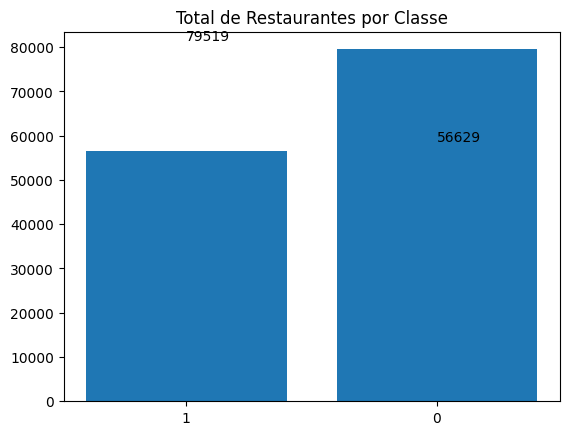

In [9]:
# at rating bin, if rating >= 4.5, rating_max = 1, else rating_max = 0
data['rating_max'] = data['rating'].apply(lambda x: 1 if x >= 4.5 else 0)


# Count the occurrences of each class
class_counts = data['rating_max'].value_counts()

# Create the bar plot
plt.bar(class_counts.index, class_counts.values)

# Annotate each bar with the count of the class
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 2000, str(v))

plt.xticks(class_counts.index, ['0', '1'])
plt.title('Total de Restaurantes por Classe')
plt.show()

O que um restaurante nota > 4.7 precisa ter? 

In [10]:
elite = data[data['rating_max'] == 1]
not_elite = data[data['rating_max'] == 0]

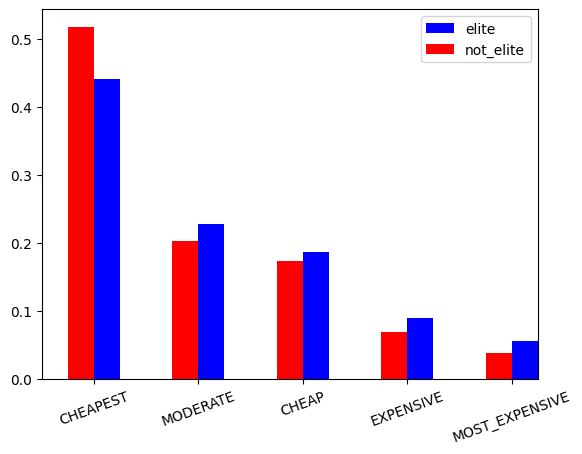

In [11]:
#plotando a distribuição de preços dos restaurantes com rating >= 4.7 e < 4.7 com dados normalizados para preservar a proporção 
fig, ax = plt.subplots()
(elite['price_range'].value_counts()/elite['price_range'].count()).plot.bar(ax=ax, color='blue', position=0, width=0.25, label='elite')
(not_elite['price_range'].value_counts()/not_elite['price_range'].count()).plot.bar(ax=ax, color='red', position=1, width=0.25, label='not_elite')
plt.xticks(rotation=20)
plt.legend()
plt.show()

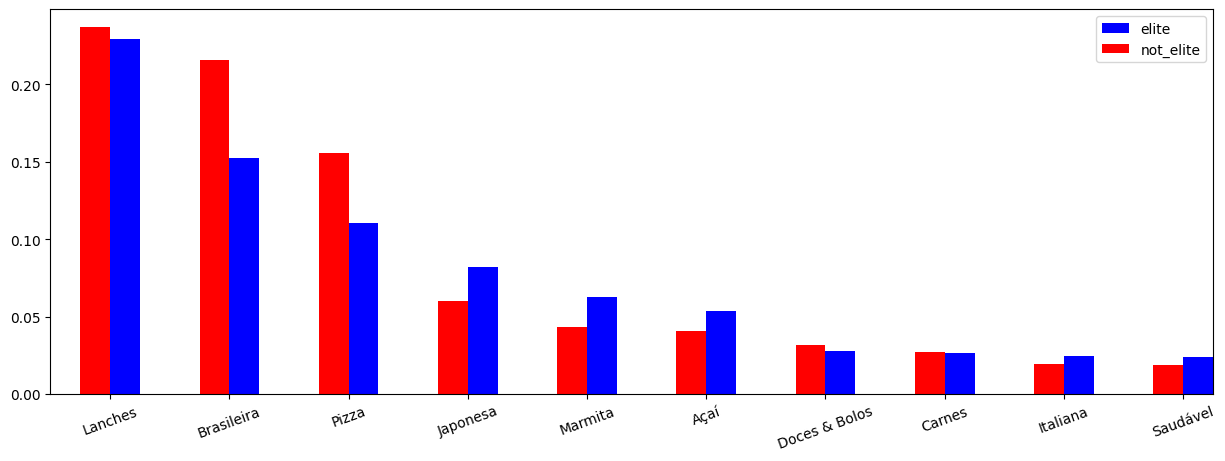

In [12]:
#plot category of elite vs not elite restaurants for categories with more than 1000 restaurants
fig, ax = plt.subplots(figsize=(15,5))
(elite['category'].value_counts()[elite['category'].value_counts() > 1000]/elite['category'].count()).plot.bar(ax=ax, color='blue', position=0, width=0.25, label='elite')
(not_elite['category'].value_counts()[not_elite['category'].value_counts() > 1000]/not_elite['category'].count()).plot.bar(ax=ax, color='red', position=1, width=0.25, label='not_elite')
plt.xticks(rotation=20)

#increase plot size to see all categories 
plt.legend()
plt.show()

In [13]:
print(elite['delivery_time'].mean())
print(not_elite['delivery_time'].mean())

44.04898200430086
48.44116971869537


In [14]:
print(elite['delivery_fee'].mean())
print(not_elite['delivery_fee'].mean())

7.044214590223719
6.462566882692612


In [15]:
print(elite['minimumOrderValue'].mean())
print(not_elite['minimumOrderValue'].mean())

15.733801481406962
17.434437832206115


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136148 entries, 0 to 136147
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   availableForScheduling  136148 non-null  bool    
 1   avatar                  136136 non-null  object  
 2   category                136148 non-null  object  
 3   delivery_fee            136148 non-null  float64 
 4   delivery_time           136148 non-null  int64   
 5   distance                136148 non-null  float64 
 6   ibge                    136148 non-null  int64   
 7   minimumOrderValue       136148 non-null  float64 
 8   name                    136148 non-null  object  
 9   paymentCodes            136148 non-null  object  
 10  price_range             136148 non-null  object  
 11  rating                  136148 non-null  float64 
 12  tags                    136148 non-null  object  
 13  url                     136148 non-null  object  
 14  rati

In [17]:
data_ml = pd.get_dummies(data, columns=['category','price_range'], prefix = ['category','price_range'])
data_ml['availableForScheduling'] = data['availableForScheduling'].apply(lambda x: 0 if x == 'False' else 1)
data_ml['isElite'] = data['rating'].apply(lambda x: 1 if x >= 4.5 else 0)



data_ml = data_ml.drop(['distance','ibge','name','paymentCodes','tags','url','rating','rating_bin','rating_max'], axis=1)

In [18]:
#normalizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_ml[['delivery_time','delivery_fee','minimumOrderValue']] = scaler.fit_transform(data_ml[['delivery_time','delivery_fee','minimumOrderValue']])
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136148 entries, 0 to 136147
Data columns (total 71 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   availableForScheduling      136148 non-null  int64  
 1   avatar                      136136 non-null  object 
 2   delivery_fee                136148 non-null  float64
 3   delivery_time               136148 non-null  float64
 4   minimumOrderValue           136148 non-null  float64
 5   category_Africana           136148 non-null  uint8  
 6   category_Alemã              136148 non-null  uint8  
 7   category_Argentina          136148 non-null  uint8  
 8   category_Asiática           136148 non-null  uint8  
 9   category_Açaí               136148 non-null  uint8  
 10  category_Baiana             136148 non-null  uint8  
 11  category_Bebidas            136148 non-null  uint8  
 12  category_Brasileira         136148 non-null  uint8  
 13  category_Cafet

In [19]:
#train test split
from sklearn.model_selection import train_test_split
avatares = data_ml['avatar']
data_ml = data_ml.drop(['avatar'], axis=1)
X = data_ml.drop(['isElite'], axis=1)
y = data_ml['isElite']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [20]:
#XGBoost Classifier

# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report

# xgb = XGBClassifier()
# xgb.fit(X_train, y_train)
# y_pred = xgb.predict(X_test)
# print(accuracy_score(y_test, y_pred))

In [21]:
#Neural Network 

# from sklearn.neural_network import MLPClassifier
# mlp = MLPClassifier(hidden_layer_sizes=(20,20,20), max_iter=100)
# mlp.fit(X_train,y_train)
# predictions = mlp.predict(X_test)
# print(accuracy_score(y_test, predictions))

In [22]:
#save model
# import pickle
# pickle.dump(xgb, open('model.pkl','wb'))


## Analisando as logos



In [23]:
sample = data.sample(1)['avatar']
#get image from url and plot it 
from PIL import Image
import urllib.request
import matplotlib.pyplot as plt
pixels = 0
image = 0
url = sample.values[0]
with urllib.request.urlopen(url) as url:
    image = Image.open(url)
    # plt.imshow(image)
    
    pixels = image.getdata()


# for all the data in elite, get the image and calculate the average color 
# for each image, calculate the average color






In [24]:
from tqdm import tqdm
import urllib.request

import os
if not os.path.exists('images'):
    os.makedirs('images')
else:
    #delete all files in images folder
    for file in os.listdir('images'):
        os.remove(os.path.join('images', file))


images = [] 

indexes_to_drop = []

sleep_time = 0

for i in tqdm(range(0, len(avatares))):
    url = avatares.values[i]
    try: 
       
        
        with urllib.request.urlopen(url) as url:
            image = Image.open(url)
            images.append(image.resize((64,64)))
            images[i].save('images/'+str(i)+'.jpg')
        
            
          
    except:
        indexes_to_drop.append(i)
    continue

#save indexes_to_drop to drop from data_ml into images folder 
import pickle
pickle.dump(indexes_to_drop, open('images/indexes_to_drop.pkl','wb'))



100%|██████████| 100/100 [00:12<00:00,  7.93it/s]


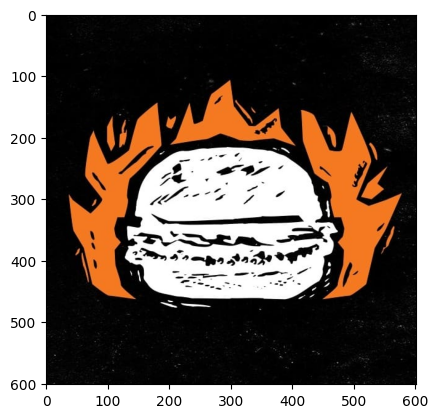

(601, 601)


In [25]:
import urllib.request

url = avatares.values[0]
with urllib.request.urlopen(url) as url:
    image = Image.open(url)
    plt.imshow(image)
    plt.show()
    print(image.size)
    print(image.getdata())

In [26]:
#if images folder does not exist, create it

#save images in folder
for i in range(0, len(images)):
    images[i].save('images/'+str(i)+'.jpg')

In [27]:
url = avatares.values[23]
#encode url to ascii
with urllib.request.urlopen(url) as url:
    image = Image.open(url)
    plt.imshow(image.resize((64,64)))


UnicodeEncodeError: 'ascii' codec can't encode character '\xc3' in position 61: ordinal not in range(128)

In [ ]:
images

NameError: name 'images' is not defined

### Color Quantization usando K-means


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.ndimage import gaussian_filter



#reduce image size to 32 x 32 
image = image.resize((160, 160)) 
pixels = image.getdata()
# Convert the pixels to a numpy array
pixels_array = np.array(pixels)



# Use the KMeans algorithm to cluster the pixels into 10 clusters
kmeans = KMeans(n_clusters=3).fit(pixels_array)


# Create a dictionary to store the frequencies of the cluster labels
cluster_freq = {}

# Iterate over the cluster labels and count the frequencies
for label in kmeans.labels_:
    if label not in cluster_freq:
        cluster_freq[label] = 1
    else:
        cluster_freq[label] += 1

# Sort the dictionary by values in descending order
sorted_clusters = sorted(cluster_freq.items(), key=lambda x: x[1], reverse=True)

background = sorted_clusters[0]
# Get the top three cluster labels but igore the first one, wich represents the background
top_three = sorted_clusters[:3]

# Print the top three cluster labels
for label, freq in top_three:
    print(label, freq)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# #background color 
# background_color = cluster_centers[background[0]].astype(int)


# Get the dominant color for each cluster
for label, freq in top_three:
    dominant_color = cluster_centers[label].astype(int)
 

0 18016
2 4231
1 3353


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image
from typing import Tuple

def extract_dominant_colors(image_path: str, n_clusters: int=3, resize: Tuple[int, int]=(160, 160)):
    # Open the image
    image = Image.open(image_path)
    # Resize the image
    image = image.resize(resize)
    # Get the pixels from the image
    pixels = image.getdata()
    # Convert the pixels to a numpy array
    pixels_array = np.array(pixels)
    # Use the KMeans algorithm to cluster the pixels
    kmeans = KMeans(n_clusters=n_clusters).fit(pixels_array)
    # Create a dictionary to store the frequencies of the cluster labels
    cluster_freq = {}
    # Iterate over the cluster labels and count the frequencies
    for label in kmeans.labels_:
        if label not in cluster_freq:
            cluster_freq[label] = 1
        else:
            cluster_freq[label] += 1
    # Sort the dictionary by values in descending order
    sorted_clusters = sorted(cluster_freq.items(), key=lambda x: x[1], reverse=True)
    # Get the top three cluster labels (ignoring the first one, which represents the background)
    top_three = sorted_clusters[:3]
    # Print the top three cluster labels
    for label, freq in top_three:
        print(label, freq)
    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_
    # Get the dominant color for each cluster
    dominant_colors = []
    for label, freq in top_three:
        dominant_colors.append(cluster_centers[label].astype(int))
    return dominant_colors

In [ ]:
from typing import Tuple, Dict
from colormath.color_diff import delta_e_cie2000
from colormath.color_conversions import convert_color
from colormath.color_objects import sRGBColor

def find_closest_color(colors: Dict[str, Tuple[int, int, int]], target_rgb: Tuple[int, int, int]) -> str:
    closest_color = ""
    closest_distance = float("inf")
    for color_name, color_rgb in colors.items():
        # Convert RGB to L*a*b* color space
        color_rgb_obj = sRGBColor(*color_rgb, is_upscaled=True)
        target_rgb_obj = sRGBColor(*target_rgb, is_upscaled=True)

        color_lab = convert_color(color_rgb_obj, LabColor)
        target_lab = convert_color(target_rgb_obj, LabColor)

        # Calculate the CIEDE2000 color difference
        distance = delta_e_cie2000(color_lab, target_lab)

        # Update the closest color and distance if a closer color is found
        if distance < closest_distance:
            closest_color_rgb = color_rgb
            closest_color = color_name
            closest_distance = distance

        
    return closest_color, closest_color_rgb